In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm

from sklearn.decomposition import PCA

import qda

Ex 1

In [2]:
data=pd.read_csv('240606_ex1.csv')
data.columns=['Sample','value']
print(data.shape)
data.head()

(50, 2)


,Sample,value
0,1,8.36
1,2,12.72
2,3,8.60
3,4,7.72
4,5,5.97


In [17]:
n=data.shape[0]

In [3]:
print(np.where(data<0))

(array([16, 17], dtype=int64), array([1, 1], dtype=int64))


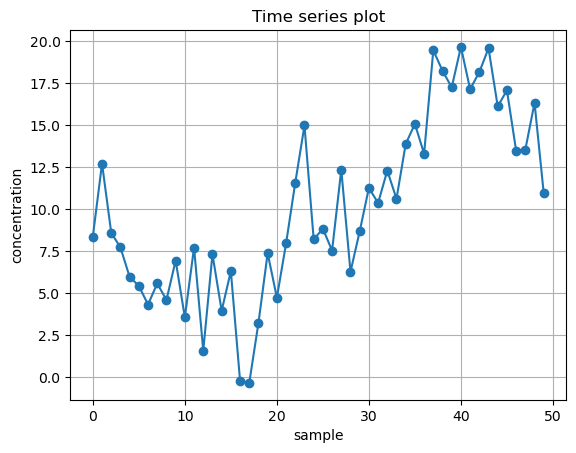

In [4]:
# Plot the data 
plt.plot(data['value'], 'o-')
plt.xlabel('sample')
plt.ylabel('concentration')
plt.title('Time series plot')
plt.grid()
plt.show()

p-value of the Shapiro-Wilk test: 0.223


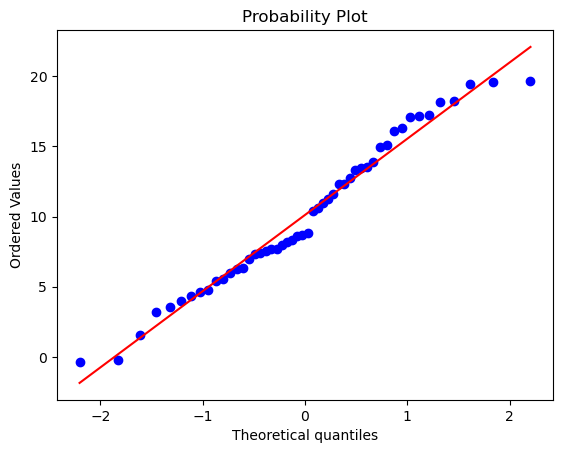

Runs test p-value = 0.000


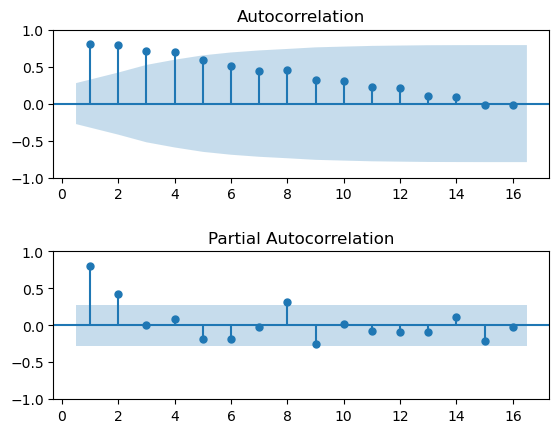

In [5]:
# Normality assumption assuming all from same population
# shapiro-wilk test
_, p_value_SW = stats.shapiro(data['value'])
print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)
# QQ-plot
stats.probplot(data['value'], dist="norm", plot=plt)
plt.show()
# assumption of random data
_, pval_runs = runstest_1samp(data['value'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['value'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['value'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

In [6]:
data['miscalibr']=np.zeros(len(data))
for i in range(len(data)):
    if data['value'][i]<0:
        data['miscalibr'][i]=1
data.head()

c:\Users\giuli\.conda\envs\qda_environment_v2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Sample,value,miscalibr
0,1,8.36,0.0
1,2,12.72,0.0
2,3,8.60,0.0
3,4,7.72,0.0
4,5,5.97,0.0


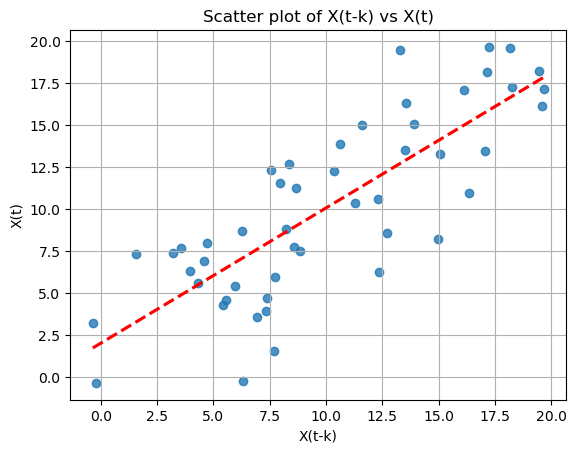

In [7]:
#calculate the lag k from data
k=1
data['lagk'] = data['value'].shift(k)

#create scatterplot with regression line using seaborn and set axis labels
sns.regplot(x=data['lagk'], y=data['value'], ci=None, line_kws={'color':'red', 'ls':'--'})
plt.title('Scatter plot of X(t-k) vs X(t)')
plt.xlabel('X(t-k)')
plt.ylabel('X(t)')
plt.title('Scatter plot of X(t-k) vs X(t)')
plt.grid()


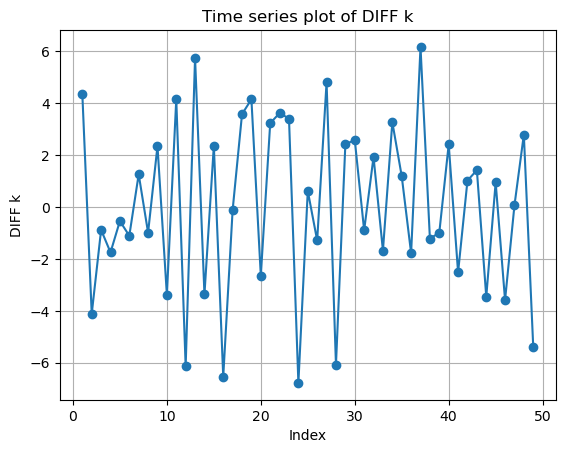

In [8]:
#calculate the difference between the data and the lagk
data['diffk'] = data['value'] - data['lagk']

plt.plot(data['diffk'], 'o-')
plt.xlabel('Index')
plt.ylabel('DIFF k')
plt.title('Time series plot of DIFF k')
plt.grid()
plt.show()

p-value of the Shapiro-Wilk test: 0.255


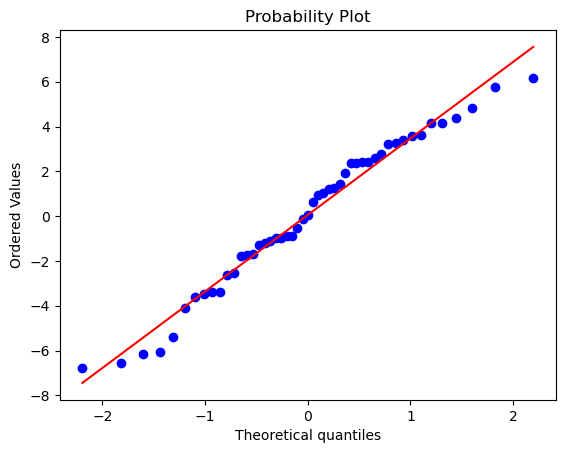

Runs test p-value = 0.002


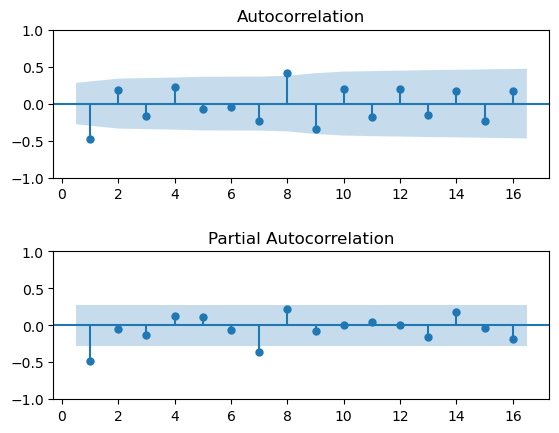

In [9]:
# Normality assumption assuming all from same population
# shapiro-wilk test
_, p_value_SW = stats.shapiro(data['diffk'][1:])
print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)
# QQ-plot
stats.probplot(data['diffk'][1:], dist="norm", plot=plt)
plt.show()
# assumption of random data
_, pval_runs = runstest_1samp(data['diffk'][1:], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['diffk'][1:], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['diffk'][1:], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

In [10]:
# y=diff because non-stationary
x = data[['lagk','miscalibr']][1:]
x = sm.add_constant(x) # this command is used to consider a constant to the model, is equivalent to create and add a column of ones
y = data['diffk'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
diffk =  + 2.779 const -0.248 lagk -5.354 miscalibr

COEFFICIENTS
------------
     Term    Coef  SE Coef  T-Value  P-Value
    const  2.7795   0.9986   2.7832   0.0078
     lagk -0.2484   0.0857  -2.8974   0.0057
miscalibr -5.3544   2.3164  -2.3115   0.0253

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
3.0871 0.1915     0.1564

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS  Adj MS  F-Value  P-Value
Regression  2.0 103.8709 51.9354   5.4494   0.0075
     const  1.0  73.8263 73.8263   7.7464   0.0078
      lagk  1.0  80.0095 80.0095   8.3952   0.0057
 miscalibr  1.0  50.9209 50.9209   5.3430   0.0253
     Error 46.0 438.4003  9.5304      NaN      NaN
     Total 48.0 542.2712     NaN      NaN      NaN


Shapiro-Wilk test p-value on the residuals = 0.357
Runs test p-value on the residuals = 0.183


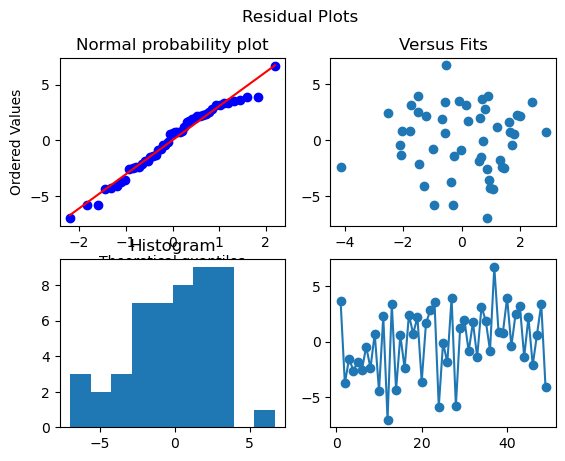

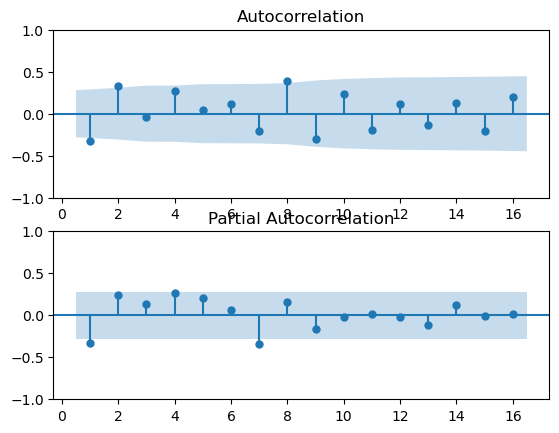

In [11]:
# Assumptions on residuals 
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

In [35]:
Xbar = data['lagk'].mean()          # sample mean of the regressor
S2_X = data['lagk'].var()           # sample variance of the regressor

print(model.model.exog_names) 
p = len(model.model.exog_names)     # number of regressors
S2_Y = np.var(model.resid, ddof=p)  # sample variance of residuals

alpha = 0.05
t_alpha = stats.t.ppf(1-alpha/2, n-2)

['const', 'lagk', 'miscalibr']


In [36]:
#predict future outcomes using the regression model
last_lag = data['diffk'].iloc[-1]

#predict the next value
Yhat = model.predict([1,last_lag,0])  #[const,lag1,dummy]
print('Next process outcome = %.3f' % Yhat)

Next process outcome = 4.118


In [37]:
# Calculate the PREDICTION interval
PI = [Yhat - t_alpha*np.sqrt(S2_Y*(1 + 1/n + ((last_lag - Xbar)**2)/((n-1)*S2_X))),
        Yhat + t_alpha*np.sqrt(S2_Y*(1 + 1/n + ((last_lag - Xbar)**2)/((n-1)*S2_X)))]

print('The prediction interval for the next value is [%.5f, %.5f]' % (PI[0], PI[1]))

The prediction interval for the next value is [-2.64655, 10.88292]


In [38]:
# this is prediction on diff1 -> sum last value to get value
PIF=PI+data['value'].iloc[-1]
print('The prediction interval for the next value is [%.5f, %.5f]' % (PIF[0], PIF[1]))

The prediction interval for the next value is [8.30345, 21.83292]


In [40]:
ARL0=250
alpha=1/ARL0
K_alpha=stats.norm.ppf(1-alpha/2)

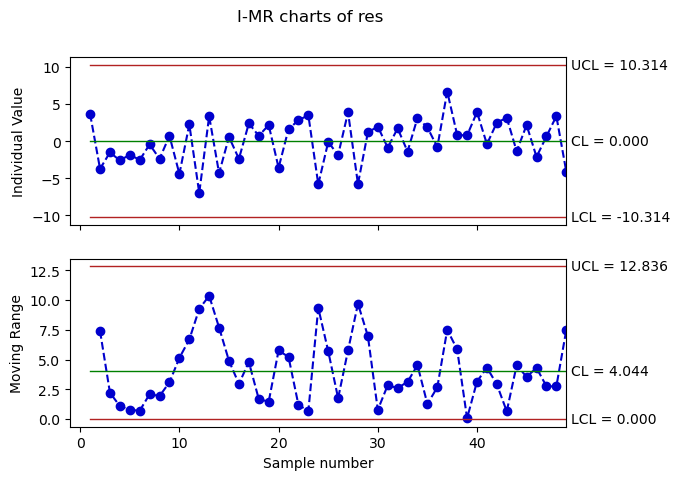

In [41]:
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(model.resid, columns=['res'])

# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res',K=K_alpha)

In [ ]:
#in control

In [63]:
sigma0=2.5

In [83]:
#  One-sided CI on the variance
# H0:sigmares<sigma0      vs     H1: sigmares>sigma0

df = n - 2      # Degrees of freedom
chi_alpha = stats.chi2.ppf(1-alpha, df)
chi0 = df * model.resid.var() / (sigma0**2)

if chi0 > chi_alpha:
    print('Reject the null hypothesis at alpha = %.2f' % alpha)
else:
    print('Accept the null hypothesis at alpha = %.2f' % alpha)

pval = 1 - stats.chi2.cdf(chi0, df)
print('p-value = %.3f' % pval)

Reject the null hypothesis at alpha = 0.05
p-value = 0.020


In [84]:
#bigger than historical data

Ex 2

In [11]:
ARL0=250
alpha=1/ARL0
K_alpha = stats.norm.ppf(1-alpha/2)
print(K_alpha)

2.878161739095483


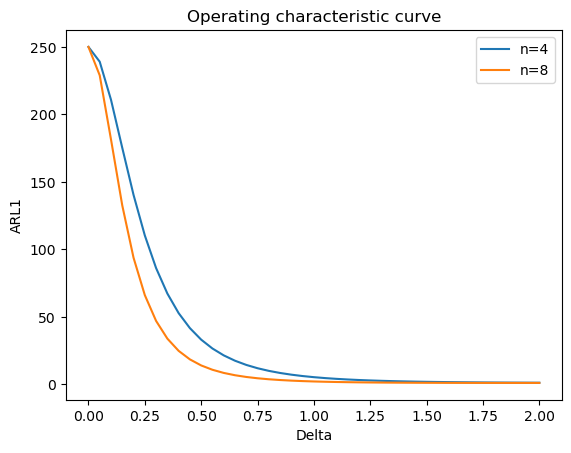

In [12]:
# Operating characteristic curve

n= [4, 8]
# Define a range of values for beta
#delta = np.linspace(0, 4, 100)
delta = np.arange(0, 2.05, 0.05)
# Compute the corresponding beta values
beta1 = stats.norm.cdf(K_alpha - delta*np.sqrt(n[0])) - stats.norm.cdf(-K_alpha - delta*np.sqrt(n[0]))
beta2 = stats.norm.cdf(K_alpha - delta*np.sqrt(n[1])) - stats.norm.cdf(-K_alpha - delta*np.sqrt(n[1]))
ARL11 = 1/(1-beta1)
ARL12 = 1/(1-beta2)

# Plot the beta values
plt.plot(delta, ARL11)
plt.plot(delta, ARL12)
plt.xlabel('Delta')
plt.ylabel('ARL1')
plt.legend(['n=4','n=8'])
plt.title('Operating characteristic curve')
plt.show()

In [14]:
print(ARL11[np.where(delta==1)])
print(ARL11[np.where(delta==2)])
print(ARL12[np.where(delta==1)])
print(ARL12[np.where(delta==2)])

[5.26513893]
[1.15070244]
[2.08260901]
[1.00273638]


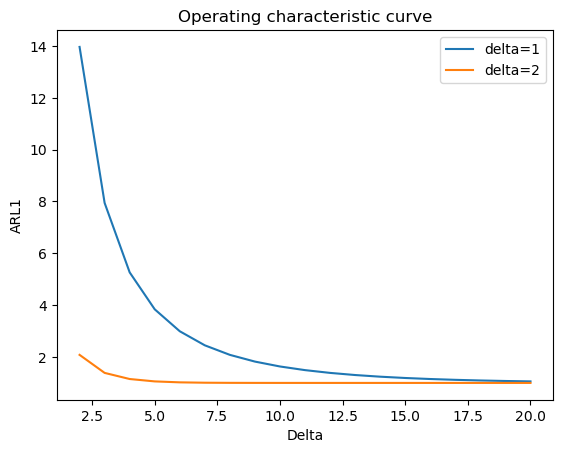

In [32]:
# Operating characteristic curve

delta= [1, 2]
# Define a range of values for beta
#delta = np.linspace(0, 4, 100)
n = np.arange(2, 21, 1)
# Compute the corresponding beta values
beta1 = stats.norm.cdf(K_alpha - delta[0]*np.sqrt(n)) - stats.norm.cdf(-K_alpha - delta[0]*np.sqrt(n))
beta2 = stats.norm.cdf(K_alpha - delta[1]*np.sqrt(n)) - stats.norm.cdf(-K_alpha - delta[1]*np.sqrt(n))
ARL11 = 1/(1-beta1)
ARL12 = 1/(1-beta2)

# Plot the beta values
plt.plot(n, ARL11)
plt.plot(n, ARL12)
plt.xlabel('Delta')
plt.ylabel('ARL1')
plt.legend(['delta=1','delta=2'])
plt.title('Operating characteristic curve')
plt.show()

In [33]:
print(ARL11[np.where(n==3)])
print(ARL11[np.where(n==6)])
print(ARL12[np.where(n==3)])
print(ARL12[np.where(n==6)])

[7.94428585]
[2.99328587]
[1.38688168]
[1.02212838]


In [34]:
delta=2
h=4
c1=2
c2=15

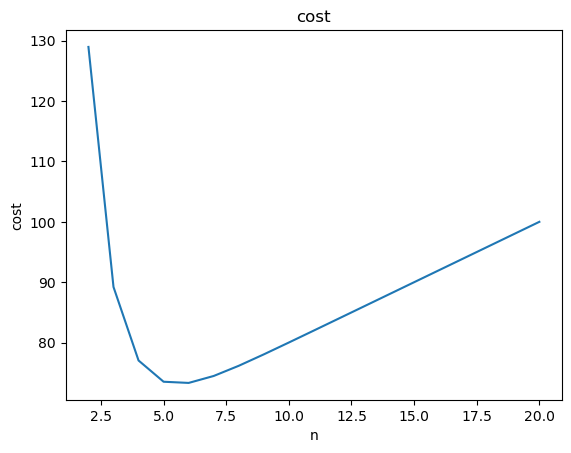

In [35]:
cost=c1*n+c2*h*ARL12
plt.plot(n, cost)
plt.xlabel('n')
plt.ylabel('cost')
plt.title('cost')
plt.show()

In [37]:
print(np.argmin(cost)+2)  #+2 because in position 0 n=2

6
